In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def divide_set(matrix):
    densidad_5_6 = matrix[:, matrix[0] < 4400]
    densidad_6_7 = matrix[:, (4400 <= matrix[0]) & (matrix[0] < 8000)]
    densidad_7_8 = matrix[:, (8000 <= matrix[0]) & (matrix[0] < 11600)]
    densidad_8_9 = matrix[:, (11600 <= matrix[0]) & (matrix[0] < 15200)]
    densidad_9_10 = matrix[:, 15200 <= matrix[0]]

    return densidad_5_6, densidad_6_7, densidad_7_8, densidad_8_9, densidad_9_10

In [3]:
# Itero sobre los results, para cada result hago:

for j in range(8):
    pos = np.load(f'npys/fast_road_11-09/pos{j}.npy')
    spd = np.load(f'npys/fast_road_11-09/spd{j}.npy')
    globals()[f'results{j}'] = np.load(f'npys/fast_road_11-09/results{j}.npy')

    new_rows = np.zeros((2, globals()[f'results{j}'].shape[1]))
    globals()[f'results{j}'] = np.vstack((globals()[f'results{j}'], new_rows))

    ide = np.load('npys/fast_road_11-09/first_ids.npy')[j]

    for i in range(globals()[f'results{j}'].shape[1]):
        window1 = np.where((pos[ide+i] >= 2000) & (pos[ide+i] <= 2500))[0]
        window2 = np.where((pos[ide+i] >= 6000) & (pos[ide+i] <= 6650))[0]
        window3 = np.where((pos[ide+i] >= 11700) & (pos[ide+i] <= 12350))[0]

        window = np.hstack((window1, window2))
        window = np.hstack((window, window3))

        window = pd.Series(window)

        index_max = int(globals()[f'results{j}'][1,i]) # fila 1, agente i --> cuando salió
        index_min = int(globals()[f'results{j}'][0,i]) # fila 0, agente i --> cuando entró

        all_indexes_for_agent = pd.Series(np.arange(len(pos[ide+i]))[index_min:index_max+1])
        out_window = all_indexes_for_agent[~all_indexes_for_agent.isin(window)]

        en_ventana = np.mean(spd[ide+i,window.to_numpy()])
        no_ventana = np.mean(spd[ide+i,out_window.to_numpy()])

        globals()[f'results{j}'][5,i] = en_ventana
        globals()[f'results{j}'][6,i] = no_ventana

In [29]:
from sklearn.neighbors import KernelDensity

curvas = {
    '5_6': [],
    '6_7': [],
    '7_8': [],
    '8_9': [],
    '9_10': [],
    'gen': []
}

# Define bandwidth and datasets
bandwidth = 0.5

for i in range(8):
    d_5_6, d_6_7, d_7_8, d_8_9, d_9_10 = divide_set(globals()[f'results{i}'])

    data_global = globals()[f'results{i}'][2,:]
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(data_global.reshape(-1, 1))
    
    x_vals = np.linspace(min(data_global), max(data_global), 10000)
    log_dens = kde.score_samples(x_vals.reshape(-1, 1))
    dens = np.exp(log_dens)

    curvas['gen'].append((x_vals, dens))

    datasets = [d_5_6, d_6_7, d_7_8, d_8_9, d_9_10]

    # Iterate through the datasets
    for j, dataset in enumerate(datasets, start=5):
        kde = KernelDensity(bandwidth=bandwidth)
        kde.fit(dataset[2, :].reshape(-1, 1))
        
        x_vals = np.linspace(min(dataset[2, :]), max(dataset[2, :]), 10000)
        log_dens = kde.score_samples(x_vals.reshape(-1, 1))
        dens = np.exp(log_dens)
        
        key = f'{j}_{j+1}'  # Create a key based on the current dataset indices
        curvas[key].append((x_vals, dens))


C:\Users\gaston\AppData\Local\Temp\ipykernel_18356\1215535934.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 28)


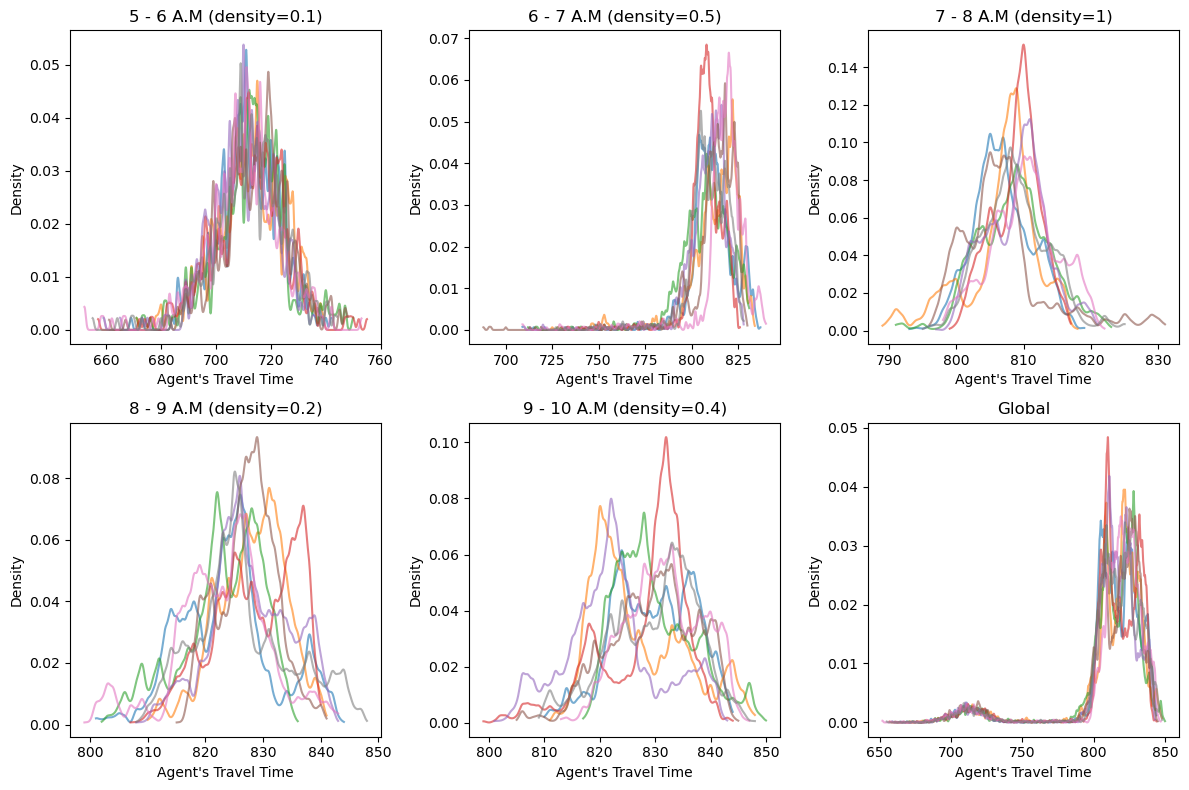

In [40]:
# Define the number of rows and columns for the grid plot
num_rows = 2  # You can adjust this based on your preferences
num_cols = 3

# Define a list of density values
density_values = [0.1, 0.5, 1, 0.2, 0.4]

# Define a function to transform keys
def transform_key(key, i):
    if key == "gen":
        return "Global"
    else:
        parts = key.split('_')
        start_hour = parts[0]
        end_hour = parts[1]
        return f"{start_hour} - {end_hour} A.M (density={density_values[i % len(density_values)]})"

cmap = plt.cm.get_cmap('tab20', 28)

# Create a subplot grid for each key in curvas
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
color_index = 0
# Iterate through the keys in curvas and plot the curves
for i, (key, curves) in enumerate(curvas.items()):
    row = i // num_cols
    col = i % num_cols
    
    ax = axs[row, col]
    
    # Transform the key to the desired format
    transformed_key = transform_key(key, i)
    ax.set_title(transformed_key)
    
    for x_vals, dens in curves:
        color = colors(j) 
        ax.plot(x_vals, dens, alpha=0.6)
        color_index += 1
    
    ax.set_xlabel("Agent's Travel Time")
    ax.set_ylabel('Density')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# d0, _, _, _, _ = divide_set(results0)
# from sklearn.neighbors import KernelDensity
   
# data = d0[2,:]

# # Step 3: Fit an empirical curve (Kernel Density Estimation)
# kde = KernelDensity(bandwidth=0.5)  # You can adjust the bandwidth
# kde.fit(data.reshape(-1, 1))

# # Step 4: Generate values for the empirical curve
# x_vals = np.linspace(min(data), max(data), 1000)
# log_dens = kde.score_samples(x_vals.reshape(-1, 1))
# dens = np.exp(log_dens)

# # Step 5: Plot the histogram and the empirical curve
# plt.hist(data, bins=20, density=True, alpha=0.6, color='b', label='Histogram')
# plt.plot(x_vals, dens, 'k-', linewidth=2, label='Empirical Curve')

# # Add labels and legend
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()

# # Show the plot
# plt.show()